In [ ]:
!pip install cybotrade_datasource
!pip install python-dotenv
!pip install hmmlearn
!pip install bt

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from hmmlearn.hmm import GaussianHMM
import bt 
from sklearn.preprocessing import StandardScaler



import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')


global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open  volume
0     1743829560000  83689.6  83689.6  83660.1  83660.1  17.686
1     1743829620000  83661.5  83710.0  83661.5  83689.6  23.948
2     1743829680000  83656.2  83669.1  83656.2  83661.5  17.478
3     1743829740000  83670.0  83670.0  83656.2  83656.2   4.154
4     1743829800000  83705.7  83715.3  83670.0  83670.0   8.516
...             ...      ...      ...      ...      ...     ...
9995  1744429260000  83080.0  83088.0  83046.4  83050.7  16.851
9996  1744429320000  83083.8  83093.8  83062.1  83080.0  21.932
9997  1744429380000  83025.9  83087.3  83025.9  83083.8  13.515
9998  1744429440000  83080.9  83080.9  83025.9  83025.9  14.845
9999  1744429500000  830

In [3]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-05 05:06:00
1    2025-04-05 05:07:00
2    2025-04-05 05:08:00
3    2025-04-05 05:09:00
4    2025-04-05 05:10:00
...                  ...
9995 2025-04-12 03:41:00
9996 2025-04-12 03:42:00
9997 2025-04-12 03:43:00
9998 2025-04-12 03:44:00
9999 2025-04-12 03:45:00

[10000 rows x 1 columns]


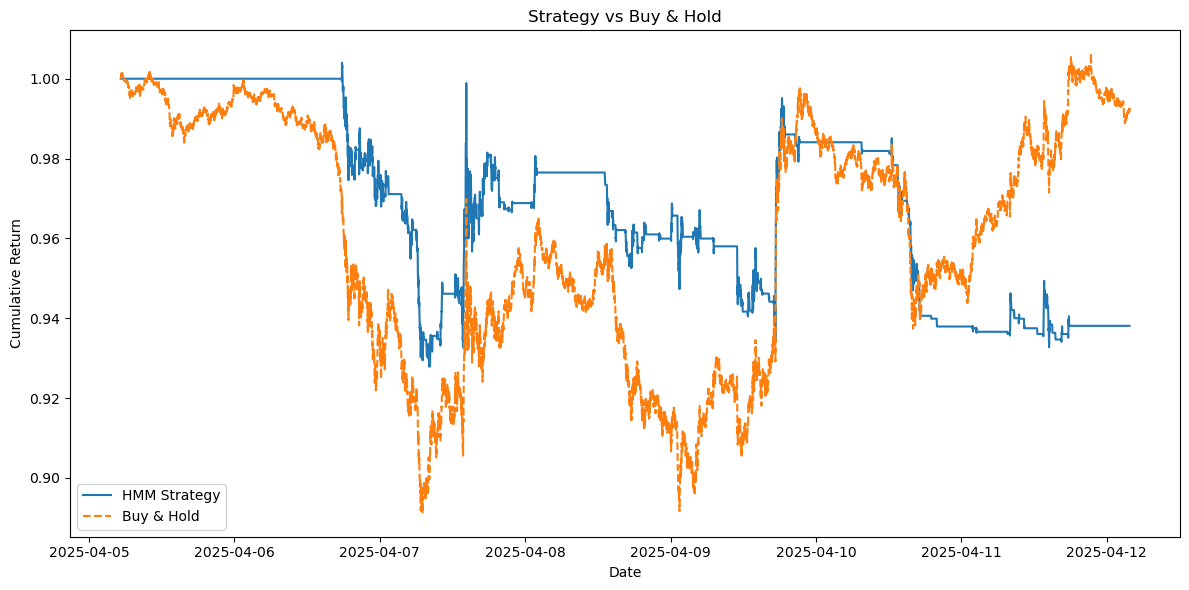

Sharpe Ratio: -0.12
Total Return: -6.19%
Max Drawdown: -7.59%
Trade Frequency: 2.19%


In [ ]:
global_df['RangeVol'] = global_df['high'] - global_df['low']
global_df['VolCluster'] = global_df['close'].rolling(window=10).std()
epsilon = 1e-6
global_df['upper_wick'] = global_df['high'] - global_df[['open', 'close']].max(axis=1)
global_df['lower_wick'] = global_df[['open', 'close']].min(axis=1) - global_df['low']
global_df['wick_ratio'] = (global_df['upper_wick'] + global_df['lower_wick']) / (global_df['high'] - global_df['low'] + epsilon)


global_df = global_df.dropna(subset=['VolCluster']).reset_index(drop=True)


scaler = StandardScaler()
global_df[['RangeVol', 'VolCluster', 'wick_ratio']] = scaler.fit_transform(
    global_df[['RangeVol', 'VolCluster', 'wick_ratio']]
)


X = global_df[['RangeVol', 'VolCluster', 'wick_ratio']].values
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=200, random_state=42)
model.fit(X)
global_df['state'] = model.predict(X)

# Signal
global_df['return'] = global_df['close'].pct_change()
returns_by_state = global_df.groupby('state')['return'].mean()
good_state = returns_by_state.idxmax()


global_df['signal'] = np.where(global_df['state'] == good_state, 1, 0)

# backtest
global_df['strategy_return'] = global_df['signal'].shift(1) * global_df['return']
fee = 0.0006
global_df['trade_occurred'] = global_df['signal'].diff().fillna(0) != 0
global_df['strategy_return_net'] = np.where(
    global_df['trade_occurred'], global_df['strategy_return'] - fee, global_df['strategy_return']
)


cumulative = (1 + global_df['strategy_return_net'].fillna(0)).cumprod()
buy_hold = (1 + global_df['return'].fillna(0)).cumprod()
sharpe = global_df['strategy_return_net'].mean() / global_df['strategy_return_net'].std() * np.sqrt(252)
cumulative_return = cumulative.iloc[-1] - 1
drawdown = cumulative / cumulative.cummax() - 1
max_dd = drawdown.min()
trade_freq = (global_df['signal'].diff() != 0).sum() / len(global_df)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(global_df['start_time'], cumulative, label='HMM Strategy')
plt.plot(global_df['start_time'], buy_hold, label='Buy & Hold', linestyle='--')
plt.title("Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Return: {cumulative_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Trade Frequency: {trade_freq:.2%}")
